In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms,datasets
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import os 
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/tif'
images = [os.path.join(PATH,i) for i in os.listdir(PATH)]
split = 0.7
train_idx = math.floor(0.8*len(images))
train_images = images[:train_idx]
test_images = images[train_idx:]

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_list,transform):
        super(MyDataset, self).__init__()
        self.img_list = img_list
        

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = self.img_list[idx]
        return self.tranform(img)

In [ ]:
data_dir = 'dataset'

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(), ])
test_transform = transforms.Compose([
    transforms.ToTensor(), ])
train_dataset = MyDataset(train_images,train_transform)
test_dataset = MyDataset(test_images,test_transform)
# train_dataset = torchvision.datasets.MNIST(data_dir, train = True, download = True)
# test_dataset = torchvision.datasets.MNIST(data_dir, train = False, download = True)

print(len(train_dataset))
print(len(test_dataset))

455
114


In [ ]:
# train_transform = transforms.Compose([
#     transforms.ToTensor(), ])
# test_transform = transforms.Compose([
#     transforms.ToTensor(), ])


In [ ]:
# train_dataset.transform = train_transform
# test_dataset.transform = test_transform

In [ ]:
m = len(train_dataset)

In [ ]:
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)]) 
batch_size = 4

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x


In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)


In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

We also would like to see the reconstructed images during each epoch of the training. The goal is to understand how the autoencoder is learning from the input images.

In [ ]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

test_dataset[i][0].unsqueeze(0) is used to extract the ith image from the test dataset and then it will be increased by 1 dimension on the 0 axis. This step is needed to pass the image to the autoencoder.

decoder(encoder(img))is used to obtain the reconstructed image

plt.imshow(img.cpu().squeeze().numpy())is used to plot the original image. squeeze()removes the dimension added before and is essential to visualize the image. numpy() transforms a tensor into a n-dimensional array, which is the only type of object accepted by the function plt.imshow. numpy() returns a copy of the tensor object into CPU memory.

In [ ]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

AttributeError: ignored

In [ ]:
test_epoch(encoder, decoder, device, test_loader, loss_fn).item()

0.025976430624723434

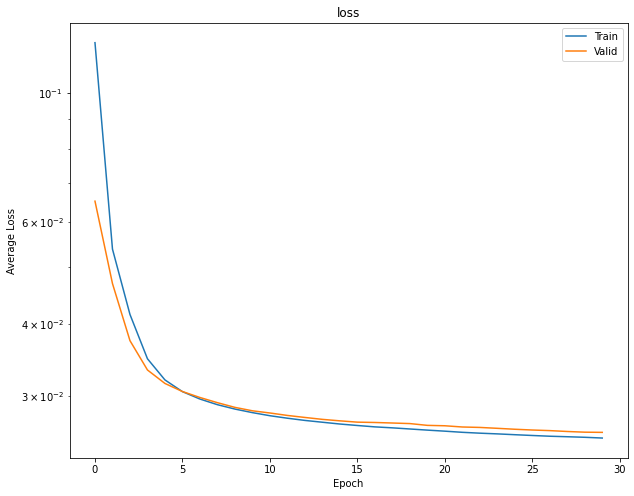

In [ ]:
# plot losses
plt.figure(figsize = (10,8))
plt.semilogy(diz_loss['train_loss'], label = 'Train')
plt.semilogy(diz_loss['val_loss'], label = 'Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')

#plt.grid()
plt.legend()
plt.title('loss')
plt.show()

# Arabic Handwritten Text Images

## Data Analysis

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

In [ ]:
PATH = '/content/drive/MyDrive/tif'
images = [os.path.join(PATH,i) for i in os.listdir(PATH)]
split = 0.7
train_idx = math.floor(0.8*len(images))
train_images = images[:train_idx]

test_images = images[train_idx:]

In [ ]:
print(f"Total of {len(train_images)} training images")
print(f"Total of {len(test_images)} test images")

Total of 455 training images
Total of 114 test images


In [ ]:
random_imgs = random.sample(images, 9)
random_imgs = [Image.open(i) for i in random_imgs]

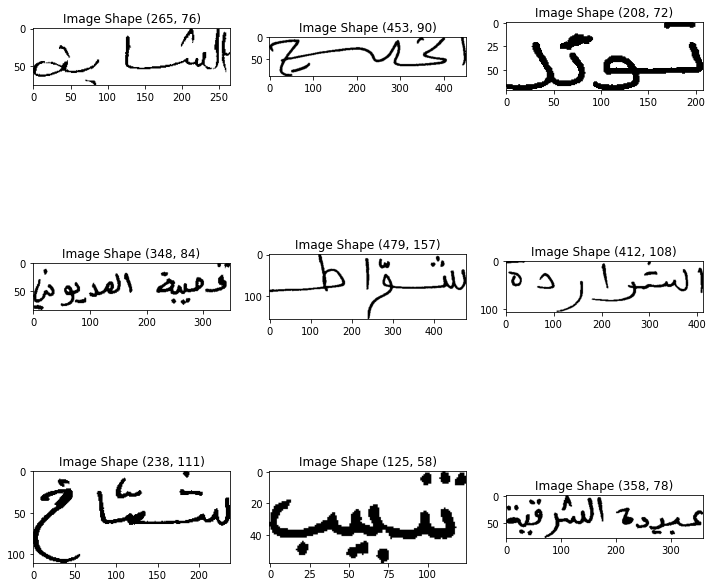

In [ ]:
_, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(random_imgs, axs):
    ax.imshow(img)
    ax.title.set_text(f'Image Shape {img.size}')
plt.show()

## Dataset Preparation

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_list,transform):
        super(MyDataset, self).__init__()
        self.img_list = img_list
        self.transform = transform       

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img = Image.open(img_name)
        return self.transform(img),img.size

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),transforms.Resize((250,80))])
test_transform = transforms.Compose([
    transforms.ToTensor(),transforms.Resize((250,80))])
train_dataset = MyDataset(train_images,train_transform)
test_dataset = MyDataset(test_images,test_transform)
# train_dataset = torchvision.datasets.MNIST(data_dir, train = True, download = True)
# test_dataset = torchvision.datasets.MNIST(data_dir, train = False, download = True)

In [ ]:
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)]) 
batch_size = 4

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

## Autoencoder for Handwritten Images

In [ ]:
class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, latent_dim)
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(num_input_channels=1, base_channel_size=32, latent_dim=64)
decoder = Decoder(num_input_channels=1, base_channel_size=32, latent_dim=64)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=1024, bias=True)
    (1): GELU(approximate='none')
  )
  (net): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): GELU(approximate='none')
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU(approximate='none')
    (8): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (9): Tanh()
  )
)

In [ ]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

RuntimeError: ignored

In [1]:
import warnings
warnings.filterwarnings('ignore')

from models.dataset import IAMDataset2,IAMDataset,IAMSubset
from models.layers import VariationalEncoder,Decoder
from experiment_utils.utils import train_epoch,test_epoch
from PIL import Image
from math import floor
from statistics import mean
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

DEBUG:git.cmd:Popen(['git', 'version'], cwd=/home/mujahid/PycharmProjects/ssl_wordspotting, universal_newlines=False, shell=None, istream=None)
DEBUG:git.cmd:Popen(['git', 'version'], cwd=/home/mujahid/PycharmProjects/ssl_wordspotting, universal_newlines=False, shell=None, istream=None)
DEBUG:matplotlib:matplotlib data path: /home/mujahid/anaconda3/envs/pytorch_sample/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/mujahid/.config/matplotlib
DEBUG:matplotlib:matplotlib version 3.4.3
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', 'posixpath', 'genericp

DEBUG:matplotlib:CACHEDIR=/home/mujahid/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/mujahid/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
iam_test_dataset = IAMDataset2('test')

INFO:root:1861 dirs for test set
INFO:root:1861 dirs for test set


In [12]:
a  = iam_test_dataset.get_query_list()

In [3]:
len(iam_test_dataset)

17616

In [5]:
print(len(iam_test_dataset))
labels = list()
for img_id, img, label, encoded_label in iam_test_dataset:
    labels.append(label)
print(len(labels))

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5889
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5942 16890
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5888
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5941 6918
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5889
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5942 19069
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5888
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5941 6711
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5889
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5942 4160
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5889
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5942 101
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5889
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5

17616


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5888
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5941 8435
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5888
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5941 11136
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5888
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5941 11038
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5889
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5942 16286
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5889
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5942 33
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5889
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5942 4259
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5889
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5129
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5182 10384
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5128
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5181 8188
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5130
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5183 10797
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5130
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5183 7047
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5130
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5183 9337
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5130
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5183 211
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5130
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4264
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4317 5345
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4264
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4317 3335
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4264
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4317 2821
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4264
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4317 4615
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4263
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4316 2014
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4265
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4318 10895
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4264
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4095
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4148 14245
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4095
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4148 10764
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4093
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4146 2110
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4094
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4147 11033
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4095
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4148 3078
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4095
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4148 4741
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4094
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT'

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5960
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6013 9905
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5960
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6013 6227
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5961
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6014 2123
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5962
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6015 3018
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5960
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6013 1737
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5962
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6015 326
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5961
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 601

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5962
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6015 3759
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5961
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6014 12066
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5960
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6013 6810
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3686
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3739 8684
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3686
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3739 154
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3685
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3738 2346
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3686
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 37

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3686
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3739 1157
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3685
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3738 2890
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3685
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3738 9880
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3685
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3738 4999
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3685
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3738 10350
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3685
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3738 9283
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3686
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3956
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4009 17083
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3955
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4008 18155
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3955
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4008 11907
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3956
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4009 10219
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3954
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4007 14506
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3955
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4008 121
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3955
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4075
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4128 6398
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4076
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4129 15594
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4075
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4128 598
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4076
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4129 59
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4076
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4129 16874
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4076
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4129 15745
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4075
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5280
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5333 8400
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5281
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5334 428
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5281
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5334 32768
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5279
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5332 2442
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5279
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5332 12261
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5281
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5334 2629
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5281
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5280
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5333 850
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5281
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5334 5937
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5281
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5334 5693
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5280
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5333 5182
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5279
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5332 12426
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5279
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5332 6943
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5281
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 53

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3860
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3913 3259
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3859
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3912 8197
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3860
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3913 4225
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3860
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3913 4209
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3860
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3913 58
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3860
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3913 2888
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3860
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3913

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4261
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4314 18247
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4262
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4315 12609
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4262
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4315 10655
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4262
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4315 4108
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4260
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4313 12693
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4261
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4314 1913
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4262
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4898
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4951 3090
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4898
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4951 2863
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4898
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4951 4794
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4898
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4951 6918
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4898
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4951 2568
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4897
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4950 4767
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4898
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 49

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4898
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4951 1317
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4898
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4951 4203
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4898
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4951 7389
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5816
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5869 21953
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5818
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5871 5407
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5818
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5871 22814
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5818
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5818
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5871 18017
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5817
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5870 7114
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5818
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5871 8008
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5818
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5871 32768
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5818
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5871 32768
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5818
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5871 5873
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5816
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT'

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5252
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5305 7265
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5253
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5306 263
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5251
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5304 8217
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5252
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5305 7898
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5253
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5306 2980
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5252
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5305 4664
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5253
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 530

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3424
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3477 954
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3423
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3476 5316
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3424
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3477 449
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3424
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3477 3367
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3424
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3477 2368
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3424
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3477 6755
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3424
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3477

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6863
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6916 6638
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6863
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6916 6484
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6864
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6917 4237
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6862
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6915 2711
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6863
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6916 1085
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6863
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6916 1401
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6862
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 69

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6863
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6916 3544
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6864
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6917 3870
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6862
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6915 2261
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6863
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6916 4759
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6863
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6916 3251
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6864
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6917 6279
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6863
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 69

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3895
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3948 2032
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3895
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3948 4103
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3896
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3949 3357
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3897
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3950 896
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3896
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3949 4092
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3896
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3949 2919
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3896
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 394

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4659
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4712 1891
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4660
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4713 2577
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4661
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4714 6557
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4661
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4714 1376
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4661
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4714 2047
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4659
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4712 2437
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4659
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 47

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4661
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4714 1037
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4659
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4712 4308
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4661
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4714 7269
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4660
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4713 2385
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4659
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4712 6749
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4661
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4714 10005
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4660
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4936
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4989 3340
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4936
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4989 2670
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4936
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4989 1282
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4935
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4988 1901
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4938
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4991 16206
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4937
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4990 2343
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4937
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3221
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3274 3086
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3222
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3275 3080
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3221
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3274 2527
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3222
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3275 7342
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3222
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3275 7892
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3221
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3274 5077
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3222
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 32

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6353
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6406 3449
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6352
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6405 3499
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6352
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6405 2454
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6352
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6405 3443
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6352
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6405 4374
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6353
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6406 2279
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6351
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 64

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6351
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6404 3507
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6353
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6406 2440
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6351
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6404 1725
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6352
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6405 1031
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6352
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6405 2476
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4861
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4914 1372
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4860
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 49

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4861
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4914 4567
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4861
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4914 7836
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4861
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4914 9431
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4861
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4914 4055
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4861
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4914 6768
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4861
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4914 1796
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4861
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 49

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4830
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4883 14109
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4830
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4883 5774
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4830
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4883 5856
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4830
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4883 4939
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4829
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4882 9505
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4829
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4882 5406
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4830
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6349
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6402 4495
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6348
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6401 5428
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6348
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6401 3882
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6347
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6400 303
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6348
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6401 7840
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6347
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6400 3655
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6348
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 640

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6349
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6402 3786
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6348
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6401 3125
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6348
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6401 3176
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6348
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6401 430
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6348
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6401 5200
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6348
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6401 3179
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6348
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 640

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5315
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5368 2524
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5316
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5369 235
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5317
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5370 2711
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5315
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5368 2026
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5316
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5369 1038
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5316
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5369 162
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5316
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5369

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7215
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7268 6763
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7216
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7269 1995
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7217
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7270 330
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7214
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7267 7290
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7216
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7269 6290
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7216
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7269 32768
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7216
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 72

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7216
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7269 4217
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7216
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7269 2658
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7216
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7269 1967
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7215
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7268 3444
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7217
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7270 4523
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7216
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7269 4261
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7216
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 72

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4083
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4136 7733
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4084
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4137 4732
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4083
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4136 6209
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4083
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4136 5846
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4084
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4137 2434
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4085
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4138 8122
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4084
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5459
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5512 11539
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5460
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5513 2097
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5459
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5512 2400
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5460
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5513 703
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5459
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5512 1991
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5459
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5512 1715
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5459
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 55

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5458
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5511 2459
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5457
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5510 623
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5458
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5511 1303
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5458
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5511 5277
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5460
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5513 1369
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5459
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5512 4698
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5457
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 551

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3747
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3800 1011
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3748
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3801 6041
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3748
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3801 3948
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3748
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3801 3627
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3748
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3801 2961
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3748
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3801 1559
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3747
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 38

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4926
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4979 4339
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4926
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4979 3703
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4926
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4979 3442
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4926
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4979 1942
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4926
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4979 6547
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4927
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4980 3741
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4927
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 49

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4927
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4980 4277
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4927
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4980 3558
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4927
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4980 3532
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4926
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4979 2929
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4927
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4980 3108
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4928
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4981 8242
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4926
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 49

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5258
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5311 590
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5256
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5309 5442
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5257
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5310 3709
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5258
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5311 3432
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5257
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5310 2887
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5257
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5310 2970
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5257
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 531

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3906
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3959 4141
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3906
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3959 1580
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3906
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3959 2367
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3905
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3958 6638
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3905
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3958 2197
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3905
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3958 1261
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3905
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 39

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4902
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4955 3635
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4900
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4953 120
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4901
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4954 3178
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4902
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4955 6959
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4900
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4953 2929
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4900
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4953 4909
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4901
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 495

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4405
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4458 83
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4405
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4458 126
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4405
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4458 190
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4405
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4458 2004
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4406
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4459 84
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4405
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4458 1764
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4405
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4458 147

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4406
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4459 773
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4405
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4458 5011
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4405
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4458 473
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4405
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4458 173
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4406
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4459 3361
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4406
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4459 1045
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4406
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4459 5231
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 1

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3811 51
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3757
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3810 1701
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3757
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3810 118
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3759
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3812 3460
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3759
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3812 2322
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3758
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3811 2184
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3758
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3811 2738
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4344
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4397 175
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4343
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4396 2466
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4344
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4397 2074
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4344
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4397 5693
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4344
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4397 3769
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4344
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4397 1330
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4344
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 439

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4472
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4525 1689
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4474
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4527 1508
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4471
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4524 7687
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4473
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4526 4244
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4473
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4526 1483
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4473
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4526 3084
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4473
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 45

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3628
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3681 13610
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3629
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3682 13023
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3628
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3681 4162
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3628
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3681 6643
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3628
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3681 10159
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3630
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3683 75
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3629
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4870
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4923 3468
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4870
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4923 13387
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4869
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4922 2584
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4869
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4922 6341
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4871
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4924 4667
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4870
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4923 5519
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4869
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4871
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4924 11679
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4869
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4922 1610
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4870
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4923 592
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4869
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4922 2315
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4870
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4923 3492
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4870
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4923 19276
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4869
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4908
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4961 5219
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4907
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4960 17521
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4909
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4962 488
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4908
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4961 6030
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4909
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4962 7016
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4909
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4962 356
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4909
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 496

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2878
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2931 3785
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2876
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2929 1853
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2878
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2931 3620
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2877
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2930 2387
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2878
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2931 155
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2876
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2929 2693
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2878
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 293

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5131
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5184 5666
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5131
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5184 3890
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5132
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5185 1402
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5131
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5184 3500
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5132
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5185 5947
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5132
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5185 6623
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5132
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 51

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6409
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6462 3367
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6409
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6462 4149
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6409
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6462 4242
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6409
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6462 338
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6410
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6463 5663
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6410
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6463 25
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6409
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6462 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6409
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6462 4697
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6410
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6463 15289
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6408
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6461 7017
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6410
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6463 10536
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6408
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6461 11163
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6408
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6461 3740
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6409
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT'

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6051
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6104 7590
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6051
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6104 2609
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6050
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6103 4955
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6050
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6103 3466
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6051
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6104 8148
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6051
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6104 3044
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6051
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 61

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5133
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5186 10348
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5133
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5186 5778
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5132
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5185 4395
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5133
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5186 1369
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5132
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5185 201
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5132
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5185 51
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5132
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5185

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5273
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5326 4240
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5274
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5327 4490
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5273
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5326 675
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5272
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5325 5770
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5273
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5326 12068
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5273
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5326 6412
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5273
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 53

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5273
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5326 3178
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5273
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5326 139
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5273
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5326 9010
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5273
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5326 2378
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3171
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3224 4724
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3172
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3225 2928
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3170
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 322

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3172
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3225 12750
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3170
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3223 67
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3170
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3223 13223
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3170
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3223 1133
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3170
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3223 3336
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3170
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3223 3869
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3170
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 32

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3126
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3179 7200
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3125
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3178 11895
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3126
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3179 15124
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3126
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3179 5912
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3126
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3179 3712
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3124
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3177 2351
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3126
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3410
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3463 12156
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3411
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3464 10
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3410
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3463 4062
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3411
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3464 290
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3411
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3464 1325
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3411
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3464 218
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3411
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3464 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3410
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3463 8000
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3411
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3464 1335
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3411
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3464 6516
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3411
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3464 8590
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3410
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3463 367
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3410
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3463 9534
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3411
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 346

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3406
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3459 2385
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3406
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3459 306
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3406
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3459 4711
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3406
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3459 17912
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3407
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3460 1335
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3407
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3460 320
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3406
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 345

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6404
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6457 5716
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6405
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6458 12109
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6404
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6457 1924
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6405
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6458 14068
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6405
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6458 9926
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6405
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6458 3694
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6405
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6405
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6458 495
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6405
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6458 13668
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6404
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6457 11319
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6406
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6459 92
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6405
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6458 13977
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6404
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6457 4963
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6405
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 64

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4929
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4982 5592
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4929
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4982 1046
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4928
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4981 8359
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4929
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4982 3897
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4930
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4983 9520
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4930
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4983 4830
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4930
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 49

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6693
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6746 2706
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6692
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6745 3956
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6693
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6746 4089
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6693
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6746 1883
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6693
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6746 4390
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6694
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6747 7756
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6694
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 67

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6694
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6747 4417
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6693
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6746 3467
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6694
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6747 925
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6693
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6746 286
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5608
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5661 683
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5610
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5663 9373
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5609
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5662 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5610
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5663 12154
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5608
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5661 13294
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5609
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5662 537
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5608
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5661 4455
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5608
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5661 2636
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5610
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5663 7273
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5608
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5057
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5110 782
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5059
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5112 3421
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5057
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5110 4521
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5057
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5110 3136
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5059
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5112 15142
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5059
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5112 8434
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5057
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 51

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3511
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3564 8935
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3511
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3564 12173
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3510
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3563 5220
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3512
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3565 12491
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3511
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3564 8536
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3511
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3564 7187
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3511
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3510
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3563 6229
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4190
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4243 18432
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4188
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4241 6853
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4189
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4242 10868
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4190
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4243 4526
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4189
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4242 18675
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4188
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT'

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4188
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4241 7350
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4188
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4241 8778
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4189
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4242 853
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4189
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4242 11636
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4189
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4242 29966
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4189
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4242 13737
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4189
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3872
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3925 7349
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3872
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3925 6748
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3871
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3924 4037
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3872
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3925 165
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3872
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3925 24471
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3871
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3924 235
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3872
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 392

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3871
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3924 15908
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3872
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3925 8869
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3872
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3925 1801
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3872
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3925 6921
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3872
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3925 25601
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3872
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3925 14449
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3871
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT'

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3131
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3184 6618
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3131
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3184 8236
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3131
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3184 10670
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3130
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3183 1752
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3131
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3184 16739
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3130
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3183 7741
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3130
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3439
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3492 32682
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3440
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3493 119
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3440
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3493 28882
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3440
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3493 28463
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3440
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3493 15214
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3440
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3493 398
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3439
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5409
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5462 261
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5410
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5463 8817
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5409
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5462 147
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5410
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5463 4393
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5409
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5462 3214
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5409
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5462 1192
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5410
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5463

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5167
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5220 5222
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5165
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5218 313
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5166
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5219 6287
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5167
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5220 7340
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5167
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5220 4637
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5168
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5221 243
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5167
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5220

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5166
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5219 228
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5167
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5220 3527
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5166
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5219 6737
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5167
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5220 6435
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5167
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5220 4663
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5166
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5219 1763
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5167
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5220 2162
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5556 2995
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5503
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5556 1627
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5503
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5556 1947
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5504
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5557 5541
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5504
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5557 3940
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5504
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5557 59
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5504
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5557 2425
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5056
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5109 2743
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5057
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5110 6709
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5057
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5110 5195
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5058
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5111 65
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5058
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5111 1116
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5056
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5109 389
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5056
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5109 

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5057
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5110 391
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5056
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5109 2349
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5056
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5109 2093
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5056
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5109 5553
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5057
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5110 59
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5056
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5109 74
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5057
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5110 5333
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7158 4557
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7103
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7156 3902
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7103
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7156 4894
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7105
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7158 495
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7106
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7159 3132
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7103
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7156 469
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7103
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7156 2553
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7158 1508
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7104
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7157 6565
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7105
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7158 51
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7105
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7158 3445
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7104
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7157 5766
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7105
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7158 2370
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 7104
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 7157 2654
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5082
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5135 6030
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5082
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5135 5007
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5083
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5136 2647
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5082
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5135 6433
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5083
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5136 4434
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5083
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5136 2970
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5082
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 51

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4553
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4606 4684
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4553
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4606 4789
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4554
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4607 6203
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4554
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4607 1569
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4553
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4606 261
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4554
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4607 2635
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4553
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 460

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4421
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4474 2025
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4422
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4475 8470
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4422
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4475 7828
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4423
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4476 2418
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4423
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4476 318
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4421
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4474 8314
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4423
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4476 4317
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR'

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5361
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5414 6221
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5360
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5413 4251
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5362
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5415 2128
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5361
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5414 119
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5361
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5414 515
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5361
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5414 10757
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5360
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5413 5414
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3853 2164
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3799
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3852 8847
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3800
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3853 374
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3800
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3853 260
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3799
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3852 2232
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3800
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3853 641
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3800
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3853 7619
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3800
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3853 2691
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3800
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3853 2368
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3800
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3853 242
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3781
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3834 3880
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3782
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3835 2195
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3781
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3834 5731
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3780
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 383

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3781
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3834 4286
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3781
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3834 2016
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3781
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3834 277
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3781
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3834 4869
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3782
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3835 8952
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3781
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3834 3157
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3781
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3834 12273
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4283
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4336 88
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4281
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4334 3966
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4283
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4336 74
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4283
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4336 6714
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4281
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4334 2908
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4283
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4336 2012
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4282
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4335 2999
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4009 470
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3958
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4011 211
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3956
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4009 1181
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3958
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4011 111
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3958
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4011 7050
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3956
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4009 205
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3959
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4012 3692
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3958
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4011 3700
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3958
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4011 2189
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3956
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4009 217
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4036
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4089 934
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4037
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4090 65
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4035
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4088 2275
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4036
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4089 2

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4036
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4089 2071
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4036
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4089 5395
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4036
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4089 3181
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4036
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4089 3786
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4036
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4089 5259
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4036
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4089 4800
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4036
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 40

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4778
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4831 4720
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4779
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4832 4238
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4779
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4832 2777
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4779
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4832 99
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4779
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4832 4680
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4780
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4833 111
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4779
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4832 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5477
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5530 813
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5476
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5529 1248
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5476
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5529 3015
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5478
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5531 2712
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5476
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5529 2305
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5476
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5529 2143
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5477
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 553

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5477
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5530 246
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5478
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5531 3236
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5477
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5530 35
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5476
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5529 1853
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5478
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5531 1720
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5476
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5529 1616
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5476
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5529 280
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4634
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4687 1591
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4634
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4687 3969
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4634
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4687 59
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4635
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4688 1639
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4634
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4687 1232
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4635
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4688 5925
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4635
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4688 2616
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5951
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6004 2156
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5949
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6002 2747
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5949
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6002 2213
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5949
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6002 3039
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5950
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6003 607
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5950
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6003 1155
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5949
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6002 2825
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR'

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5948
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6001 3079
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5950
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6003 3618
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5949
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6002 4918
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5949
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6002 5118
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5142
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5195 1412
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5140
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5193 1053
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5142
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5195 4840
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5140
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5193 1410
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5142
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5195 2691
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5142
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5195 1288
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5142
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5195 3413
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5141
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5194 193
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5140
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5193 2985
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5142
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5195 6170
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5780 409
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5727
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5780 410
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5730
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5783 3609
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5729
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5782 3939
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5729
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5782 6497
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5727
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5780 3537
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5727
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5780 841
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5728
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5781 3135
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4621
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4674 3468
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4620
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4673 2344
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4621
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4674 3841
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4620
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4673 110
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4620
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4673 2479
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4620
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 467

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4621
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4674 2310
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4621
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4674 1904
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4621
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4674 3183
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4621
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4674 6764
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4621
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4674 3082
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4620
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4673 2591
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4620
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 46

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5111
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5164 139
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5111
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5164 2980
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5112
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5165 4084
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5112
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5165 1590
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5111
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5164 7483
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5111
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5164 3586
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5112
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 516

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5152
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5205 6953
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5151
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5204 2682
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5152
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5205 2179
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5152
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5205 4290
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5152
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5205 1229
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5152
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5205 3151
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5152
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5205 371
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR'

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5153
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5206 1759
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5152
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5205 7194
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5153
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5206 8187
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5153
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5206 1887
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5151
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5204 10
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5152
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5205 2868
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5152
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5205 442
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 1

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4610
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4663 4322
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4610
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4663 2164
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4609
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4662 2377
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4609
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4662 3457
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4608
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4661 2307
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4610
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4663 4756
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4609
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4662 2447
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4658 1915
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4605
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4658 179
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4606
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4659 3148
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4606
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4659 4825
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4605
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4658 3917
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4606
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4659 6086
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4606
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4659 23
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4659 32
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4606
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4659 2475
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4606
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4659 172
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4606
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4659 255
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4606
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4659 4627
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4605
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4658 3847
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4606
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4659 2736
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3744
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3797 3871
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3744
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3797 5588
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3744
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3797 1174
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3745
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3798 2398
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3744
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3797 1139
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3744
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3797 2079
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3745
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 37

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5306
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5359 2566
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5306
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5359 28
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5305
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5358 9157
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5306
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5359 2152
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5305
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5358 3238
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5306
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5359 2979
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5305
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5358

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3695
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3748 2382
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3695
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3748 3716
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3694
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3747 3953
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3694
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3747 2004
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3694
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3747 2774
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3695
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3748 2983
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3695
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3748 191
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3747 3503
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3695
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3748 5348
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3694
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3747 54
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3694
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3747 172
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3694
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3747 6709
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4633
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4686 2153
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4633
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4686 3035
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4686 5408
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4633
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4686 1891
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4633
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4686 3606
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4632
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4685 65
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4630
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4683 3309
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4632
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4685 209
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4633
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4686 5387
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4215 4477
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4163
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4216 2494
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4163
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4216 7250
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4162
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4215 5272
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4163
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4216 2362
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4163
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4216 38
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4163
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4216 793
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4411
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4464 3268
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4411
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4464 3167
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4412
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4465 3274
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4411
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4464 3881
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4409
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4462 2969
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4409
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4462 43
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4412
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4465

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4412
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4465 5245
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4593
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4646 9372
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4593
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4646 3144
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4594
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4647 253
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4594
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4647 3274
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4594
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4647 5921
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4594
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4647 6159
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4647 158
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4593
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4646 2632
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4593
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4646 4276
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4595
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4648 2711
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4593
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4646 3543
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4595
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4648 2817
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4594
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4647 6491
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4050 4423
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3997
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4050 4929
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3996
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4049 1651
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3996
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4049 1315
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3996
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4049 3458
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3997
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4050 5043
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3996
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4049 3967
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6095 4206
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6043
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6096 1958
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6043
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6096 4518
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6043
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6096 3304
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6043
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6096 3524
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6044
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6097 4300
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6043
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6096 4400
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6096 7248
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6043
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6096 4278
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6043
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6096 4702
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6043
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6096 4546
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6043
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6096 7343
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6043
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6096 4280
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6043
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6096 3484
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4540 3842
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4488
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4541 11887
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4486
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4539 17527
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4486
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4539 9623
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4487
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4540 1681
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4486
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4539 2955
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4488
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4541 2109
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4621 3939
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4567
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4620 5372
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4566
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4619 331
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4565
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4618 21379
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4566
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4619 358
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4566
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4619 291
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4566
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4619 25679
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3670 4761
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3616
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3669 11951
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3616
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3669 12280
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3616
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3669 9459
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3617
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3670 8637
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3617
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3670 7425
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3616
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3669 12526
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTX

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3605 59
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3552
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3605 1081
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3553
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3606 19083
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3552
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3605 6684
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3553
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3606 12402
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3551
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3604 20805
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3552
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3605 6283
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3603 6084
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3553
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3606 22923
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5308
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5361 6210
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5307
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5360 15833
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5308
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5361 4666
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5307
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5360 19318
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5307
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5360 9911
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTX

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5360 235
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5306
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5359 5080
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5306
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5359 5622
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5307
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5360 2131
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5307
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5360 8299
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5306
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5359 6534
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5306
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5359 6682
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3847 13628
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3795
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3848 9364
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3795
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3848 471
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3795
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3848 2142
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3795
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3848 8834
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3794
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3847 5048
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3795
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3848 10115
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4421 1526
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4369
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4422 5241
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4367
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4420 2991
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4367
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4420 6673
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4369
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4422 46
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4367
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4420 3449
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4368
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4421 1960
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5967 9826
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5914
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5967 3794
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5913
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5966 582
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5914
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5967 23051
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5913
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5966 12440
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5913
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5966 3379
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5914
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5967 14612
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5967 17204
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5914
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5967 18058
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5914
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5967 18530
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5914
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5967 67
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5914
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5967 32768
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5914
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5967 13579
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5913
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5966 3415
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTX

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4309 21315
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4257
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4310 22329
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4256
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4309 25337
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4256
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4309 7669
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4257
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4310 3821
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4257
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4310 16641
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4257
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4310 1408
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zT

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4309 5687
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4257
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4310 19447
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4300
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4353 285
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4296
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4349 121
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4297
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4350 3596
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4298
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4351 3651
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4296
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4349 2026
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4353 8727
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4299
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4352 83
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4296
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4349 4510
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4297
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4350 8078
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4296
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4349 6710
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4300
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4353 3750
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4297
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4350 5374
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4904 200
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4852
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4905 219
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4852
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4905 1057
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4852
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4905 4831
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4850
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4903 957
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4850
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4903 292
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4850
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4903 7661
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5490 2860
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5437
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5490 3010
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5436
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5489 5318
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5436
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5489 2296
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5436
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5489 3154
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5435
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5488 2553
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5437
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5490 4117
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5489 2621
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5435
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5488 901
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5435
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5488 6546
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5437
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5490 164
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5436
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5489 3509
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5437
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5490 3489
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5437
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5490 4763
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4597 3862
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4542
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4595 4074
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4542
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4595 4983
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4544
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4597 5920
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4544
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4597 3095
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4543
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4596 3686
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4544
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4597 2245
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6045 26591
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5992
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6045 3893
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5991
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6044 19598
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5991
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6044 18718
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5992
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6045 6919
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5992
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6045 12494
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5992
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6045 9939
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zT

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6045 16408
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5992
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6045 9843
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5992
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6045 5588
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5992
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6045 23158
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5992
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6045 12403
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5992
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6045 11815
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5992
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6045 8700
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zT

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3983 6066
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3930
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3983 3344
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3932
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3985 6630
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3932
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3985 9519
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3932
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3985 16451
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3931
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3984 2917
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3930
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3983 7010
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4230 1871
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4177
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4230 2366
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4176
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4229 6062
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4176
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4229 2600
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4177
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4230 9570
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4178
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4231 3679
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4177
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4230 379
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3794 3469
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3742
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3795 5439
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3743
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3796 3315
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3742
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3795 5381
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3741
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3794 2896
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3743
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3796 2014
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3741
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3794 5657
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4063 9323
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4011
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4064 6168
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4008
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4061 13374
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4011
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4064 727
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4010
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4063 1155
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4009
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4062 9173
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4009
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4062 10759
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4062 6066
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4009
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4062 1749
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4003
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4056 9157
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4002
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4055 7179
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4003
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4056 3822
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4004
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4057 3669
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4002
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4055 3917
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4056 3685
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4002
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4055 5428
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4004
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4057 414
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4003
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4056 8417
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4004
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4057 7019
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4003
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4056 7403
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4002
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4055 439
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5507 6201
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5454
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5507 5468
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5454
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5507 8725
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5454
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5507 11356
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5453
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5506 11166
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5452
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5505 8621
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5454
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5507 9324
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4565 5251
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4511
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4564 92
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4511
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4564 682
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4511
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4564 5331
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4512
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4565 969
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4511
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4564 6136
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4512
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4565 5964
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4565 260
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4511
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4564 5869
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4512
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4565 81
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4512
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4565 2247
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4512
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4565 791
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4512
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4565 3960
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4510
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4563 1412
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4074 2451
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4021
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4074 3527
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4022
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4075 2301
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4021
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4074 8172
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4022
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4075 1163
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4022
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4075 1817
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4022
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4075 6670
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4123
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4176 1248
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4122
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4175 2058
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4123
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4176 2229
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4122
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4175 5174
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4123
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4176 7826
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4124
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4177 1055
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4122
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5167
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5220 1824
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5165
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5218 2932
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5166
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5219 4616
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5166
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5219 4185
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5167
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5220 89
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5166
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5219 4175
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5166
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5219 104
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 1

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5219 302
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5165
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5218 681
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5167
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5220 787
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5166
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5219 7385
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5165
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5218 2192
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5166
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5219 1345
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5165
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5218 5431
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5278
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5331 274
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5280
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5333 3702
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5277
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5330 2075
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5278
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5331 1647
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5279
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5332 290
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5278
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5331 2181
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5279
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5332

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4967
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5020 1775
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4966
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5019 930
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4967
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5020 888
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4967
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5020 592
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4966
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5019 2715
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4966
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5019 5436
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4967
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5020 4858
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 1

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5019 2690
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4967
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5020 4711
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4967
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5020 3609
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4968
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5021 93
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4966
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5019 281
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4966
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5019 245
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4968
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5021 233
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 49

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4706
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4759 1007
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4707
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4760 2855
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4707
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4760 361
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4706
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4759 2566
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4707
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4760 2589
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4707
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4760 1446
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4706
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 475

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5204
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5257 366
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5204
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5257 2667
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5204
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5257 10
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5204
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5257 4283
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5204
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5257 1033
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5204
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5257 93
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5204
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5257 321
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 1

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5257 300
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5204
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5257 352
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5204
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5257 2584
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5204
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5257 4464
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5203
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5256 1474
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5204
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5257 2006
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5204
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5257 1579
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5329 7348
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5275
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5328 9648
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5275
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5328 6005
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5275
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5328 13722
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5274
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5327 3825
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5276
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5329 22488
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5275
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5328 7855
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3748 3335
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3696
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3749 5237
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3695
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3748 7219
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3695
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3748 3211
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3696
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3749 1826
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3694
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3747 144
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3695
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3748 227
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4378 2660
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4325
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4378 752
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4325
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4378 6647
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4325
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4378 3618
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4326
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4379 7591
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4325
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4378 6230
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4327
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4380 11411
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4380 11265
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4326
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4379 2481
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4325
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4378 8393
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4325
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4378 4529
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4327
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4380 3752
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4325
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4378 14130
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4327
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4380 2904
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3999 2782
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3946
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3999 3700
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3946
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3999 3672
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3946
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3999 9826
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3947
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4000 14316
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3947
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4000 5494
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3946
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3999 1613
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3699 2541
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3646
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3699 3658
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3646
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3699 1370
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3645
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3698 8276
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3648
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3701 8908
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3647
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3700 1972
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3647
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3700 628
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4862 2466
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4808
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4861 1794
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4809
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4862 4331
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4808
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4861 1239
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4809
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4862 5133
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4808
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4861 1364
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4809
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4862 1619
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3928 6802
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3875
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3928 191
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3876
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3929 853
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3876
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3929 191
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3875
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3928 5758
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3876
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3929 6927
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3876
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3929 3367
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4430 5011
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4378
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4431 11185
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4378
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4431 6034
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4379
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4432 10838
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4378
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4431 5748
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4378
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4431 5548
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4379
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4432 110
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4431 7468
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4379
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4432 4984
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4379
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4432 10951
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4379
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4432 7628
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4378
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4431 906
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4379
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4432 2028
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4380
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4433 3927
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5200 1528
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5146
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5199 3822
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5146
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5199 3732
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5147
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5200 2928
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5147
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5200 4900
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5146
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5199 4020
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5146
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5199 222
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4132 7412
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4079
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4132 10700
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4078
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4131 6137
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4079
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4132 131
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4079
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4132 7397
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4078
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4131 8863
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4078
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4131 13806
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4193 31312
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4140
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4193 11728
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4140
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4193 15496
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4140
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4193 18574
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4141
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4194 18480
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4141
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4194 5962
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4139
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4192 9684
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'z

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4192 10721
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4140
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4193 12911
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4139
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4192 6215
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4139
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4192 12695
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4139
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4192 6035
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4141
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4194 8012
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4141
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4194 632
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5807 7988
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5754
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5807 4172
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5754
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5807 2350
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5753
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5806 372
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5755
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5808 485
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5755
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5808 6693
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5755
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5808 7254
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4417 9655
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4365
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4418 8930
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4366
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4419 1225
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4366
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4419 15018
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4366
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4419 5291
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4365
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4418 4714
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4367
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4420 7231
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4420 7512
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4367
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4420 1617
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4366
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4419 51
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4365
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4418 236
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4365
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4418 3330
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4365
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4418 4260
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4366
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4419 6216
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5390 5033
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5338
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5391 5028
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5337
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5390 4106
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5338
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5391 15633
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5337
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5390 3961
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5337
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5390 3188
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5338
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5391 431
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2911 525
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2857
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2910 3636
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2858
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2911 1041
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2858
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2911 24710
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2858
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2911 13892
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2857
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2910 7060
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2857
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2910 5463
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5186 771
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5132
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5185 9176
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5132
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5185 3447
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5131
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5184 3393
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5131
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5184 10279
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5132
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5185 235
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5132
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5185 7885
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5049 2280
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4996
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5049 7015
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4996
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5049 4526
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4995
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5048 724
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4996
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5049 6074
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4995
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5048 9890
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4996
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5049 4117
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5048 121
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4996
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5049 8371
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4995
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5048 662
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4997
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5050 10722
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4995
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5048 650
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4529
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4582 3487
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4530
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4583 5118
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4582 11320
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4530
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4583 7652
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4529
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4582 8322
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4530
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4583 2424
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4530
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4583 7065
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4530
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4583 5826
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4529
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4582 11276
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3734 4516
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3681
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3734 16701
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3681
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3734 19280
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3680
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3733 13933
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3682
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3735 8576
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3682
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3735 9567
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3681
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3734 7685
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTX

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6433 7847
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6381
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6434 12661
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6380
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6433 11806
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6381
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6434 6702
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6381
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6434 12363
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6380
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6433 456
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6380
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6433 4606
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5132 8540
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5079
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5132 13748
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5078
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5131 463
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5077
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5130 12290
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5079
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5132 18205
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5078
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5131 20652
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5079
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5132 13531
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zT

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5131 1664
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5079
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5132 8531
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5079
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5132 4929
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5078
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5131 8923
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5079
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5132 8862
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5078
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5131 621
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5079
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5132 7321
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4983 575
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4929
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4982 20448
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4929
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4982 9381
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4930
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4983 5863
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4929
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4982 7576
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4930
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4983 5320
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4929
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4982 9772
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4103 17288
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4050
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4103 11636
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4050
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4103 3617
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4050
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4103 6505
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4051
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4104 249
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4051
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4104 20014
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4050
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4103 13480
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTX

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4468 14765
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4415
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4468 7429
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4414
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4467 18749
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4414
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4467 19559
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4414
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4467 532
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4416
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4469 12553
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4415
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4468 2819
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTX

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4467 22481
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4414
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4467 17033
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4414
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4467 10370
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4414
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4467 7107
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4415
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4468 3703
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4414
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4467 23150
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4415
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4468 369
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTX

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4720 7704
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4665
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4718 7727
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4665
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4718 6635
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4665
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4718 92
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4665
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4718 19843
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4665
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4718 1326
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4667
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4720 10534
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4352 10530
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4299
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4352 9201
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4299
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4352 173
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4299
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4352 81
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4299
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4352 2227
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4299
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4352 481
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4299
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4352 10812
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4352 7853
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4299
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4352 328
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4299
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4352 3428
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4726
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4779 2729
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4726
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4779 2193
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4727
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4780 406
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4726
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4779 8650
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4779 13858
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4727
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4780 3681
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4727
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4780 251
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4727
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4780 2770
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4727
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4780 7546
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4726
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4779 2740
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4726
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4779 6550
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4447 5601
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4394
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4447 10578
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4394
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4447 9582
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4394
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4447 4533
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4394
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4447 6523
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4395
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4448 8372
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4393
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4446 16160
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4797 3164
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4745
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4798 7125
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4744
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4797 3081
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4744
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4797 10043
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4745
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4798 5539
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4745
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4798 6553
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4744
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4797 3526
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5213 8503
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5160
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5213 6889
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5160
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5213 4190
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5160
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5213 4509
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5159
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5212 1075
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5160
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5213 101
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5160
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5213 572
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5213 304
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5160
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5213 143
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5160
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5213 5429
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5160
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5213 3075
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5160
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5213 6756
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5159
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5212 2542
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5160
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5213 1046
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3783 1377
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3730
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3783 1936
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3731
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3784 224
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3731
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3784 317
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3731
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3784 2369
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3730
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3783 1261
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3730
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3783 351
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4471 10406
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4419
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4472 8961
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4419
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4472 20448
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4419
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4472 370
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4419
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4472 459
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4418
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4471 9539
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4419
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4472 27484
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4472 45
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4419
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4472 1265
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4418
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4471 1583
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4419
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4472 5773
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4419
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4472 16710
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4418
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4471 32768
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4418
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4471 3737
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4073 240
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4019
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4072 8545
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4020
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4073 8444
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4020
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4073 280
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4020
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4073 22453
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4020
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4073 12585
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4018
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4071 398
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3868 6129
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3816
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3869 5129
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3815
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3868 9703
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3816
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3869 18572
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3816
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3869 7496
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3817
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3870 5537
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3815
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3868 7459
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4290 13155
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4237
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4290 7459
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4238
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4291 182
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4237
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4290 9225
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4238
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4291 10352
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4238
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4291 19878
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4237
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4290 2558
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4291 2409
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4238
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4291 144
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4237
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4290 13707
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4237
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4290 4005
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4237
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4290 4162
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4238
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4291 8091
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4237
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4290 7302
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3423 6615
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3369
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3422 807
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3368
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3421 65
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3370
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3423 452
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3370
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3423 7317
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3370
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3423 13745
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3370
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3423 5411
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3494 5245
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3441
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3494 19357
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3441
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3494 16309
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3441
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3494 5612
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3442
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3495 642
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3441
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3494 5495
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3441
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3494 511
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3494 19996
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3441
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3494 17101
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3441
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3494 5493
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3441
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3494 58
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3441
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3494 10545
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3441
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3494 459
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3440
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3493 7652
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3297 44
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3244
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3297 1556
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3245
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3298 6307
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3245
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3298 3720
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3245
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3298 7103
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3245
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3298 14523
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3244
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3297 4632
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3079 5102
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3028
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3081 2710
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3026
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3079 2183
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3028
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3081 1518
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3028
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3081 14790
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3026
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3079 2123
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3026
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3079 3382
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5619 4662
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5566
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5619 258
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5567
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5620 53
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5567
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5620 144
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5567
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5620 7786
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5568
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5621 5657
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5568
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5621 314
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 55

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5567
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5620 3436
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5566
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5619 4423
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5566
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5619 3131
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5567
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5620 6585
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5567
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5620 3226
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5566
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5619 3482
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5567
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 56

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4565
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4618 5655
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4565
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4618 2270
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4563
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4616 1378
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4564
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4617 924
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4563
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4616 3572
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4563
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4616 4693
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4564
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 461

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4762
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4815 7691
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4762
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4815 2955
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4760
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4813 257
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4762
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4815 4380
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4761
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4814 6368
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4761
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4814 3596
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4761
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 481

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6202
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6255 3876
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6202
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6255 7239
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6202
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6255 3983
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6201
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6254 165
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6201
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6254 7487
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6202
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6255 4059
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6201
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 625

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6202
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6255 1085
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6202
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6255 2782
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6201
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6254 5203
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6201
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6254 4306
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6202
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6255 2322
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6202
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6255 5902
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6202
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 62

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3970
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4023 3797
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3969
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4022 1835
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3970
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4023 2023
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3970
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4023 4890
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3970
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4023 7242
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3970
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4023 2127
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3970
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4023 3742
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4246 303
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4191
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4244 1741
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4192
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4245 4659
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4191
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4244 3581
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4191
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4244 3552
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4191
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4244 4249
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4191
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4244 374
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4191
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4244 59
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4192
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4245 1722
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4192
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4245 3505
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4192
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4245 4272
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4191
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4244 2185
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4193
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4246 102
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4192
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4245 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4434
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4487 551
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4431
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4484 2189
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4433
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4486 5657
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4432
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4485 2491
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4434
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4487 1776
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4432
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4485 2356
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4434
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 448

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4911
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4964 101
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4912
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4965 315
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4913
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4966 3892
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4911
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4964 541
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4912
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4965 541
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4912
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4965 429
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4912
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4965 4847
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4964 9568
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4911
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4964 2934
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4913
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4966 8179
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4912
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4965 1110
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4912
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4965 8458
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4911
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4964 3464
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4912
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4965 2255
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4353 6519
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4300
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4353 4518
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4299
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4352 2593
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4300
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4353 3401
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4299
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4352 9297
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4300
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4353 411
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4299
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4352 59
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3241 3414
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3189
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3242 3866
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3188
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3241 4721
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3187
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3240 4496
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3187
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3240 2646
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3188
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3241 3826
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3188
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3241 3903
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5258 1825
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5206
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5259 3560
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5204
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5257 3858
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5205
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5258 141
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5206
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5259 457
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5204
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5257 5100
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5206
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5259 438
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5258 2009
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5207
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5260 1678
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5207
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5260 6130
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5205
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5258 4707
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5206
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5259 128
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5204
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5257 7612
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5205
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5258 5992
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4051 3319
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3998
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4051 3973
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3997
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4050 4854
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3998
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4051 92
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3999
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4052 59
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3998
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4051 951
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3999
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4052 1056
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 39

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4931 10575
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4879
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4932 8934
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4879
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4932 12250
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4878
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4931 5405
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4879
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4932 3763
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4879
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4932 131
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4879
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4932 1639
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4932 3366
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4879
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4932 1605
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4349
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4402 74
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4349
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4402 3518
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4349
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4402 1556
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4350
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4403 5626
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4349
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4402 7356
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4349
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4402 1621
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4349
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4402 3611
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4349
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4402 488
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4349
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4402 1667
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4349
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4402 545
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4349
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4402 543
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4349
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4402 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5165
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5218 3353
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5165
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5218 3637
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5164
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5217 39
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5164
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5217 3824
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5164
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5217 3674
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5165
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5218 10363
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5163
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 521

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5165
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5218 9116
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5482
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5535 213
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5482
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5535 39
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5482
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5535 409
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5483
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5536 955
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5483
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5536 5255
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5482
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5535 36

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5483
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5536 4593
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5483
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5536 3651
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5482
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5535 4215
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5482
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5535 11325
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5483
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5536 3248
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5483
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5536 8775
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5483
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4870
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4923 2061
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4870
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4923 6124
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4870
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4923 10643
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4871
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4924 4887
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4870
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4923 2018
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4870
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4923 7364
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4869
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3394
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3447 15375
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3395
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3448 19003
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3395
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3448 12078
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3395
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3448 2504
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3396
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3449 32768
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3393
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3446 20136
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3395
DEBUG:PIL.PngImagePlugin:STREAM b'IDA

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3394
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3447 10813
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3395
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3448 12505
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3394
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3447 14872
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3395
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3448 13550
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3395
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3448 3067
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3395
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3448 8813
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3393
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3815
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3868 1737
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3815
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3868 2127
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3815
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3868 449
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3815
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3868 346
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3814
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3867 2491
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3814
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3867 324
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3815
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3868 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5151
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5204 310
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5151
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5204 8693
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5152
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5205 8354
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5152
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5205 9672
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5152
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5205 8589
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5152
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5205 4440
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5152
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 520

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3515
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3568 4234
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3515
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3568 4384
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3514
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3567 3535
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3515
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3568 6309
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3515
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3568 2943
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3515
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3568 3857
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3515
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 35

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4393
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4446 3130
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4393
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4446 5499
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4392
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4445 4127
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4391
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4444 5192
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4393
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4446 2035
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4391
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4444 3299
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4392
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 44

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4392
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4445 4666
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4391
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4444 9146
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4393
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4446 14601
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4391
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4444 1547
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4392
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4445 3932
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4392
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4445 9412
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4391
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2978
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3031 3736
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2978
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3031 1962
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2978
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3031 5770
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2978
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3031 2030
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2978
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3031 8471
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2978
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3031 62
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2978
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3031 1964
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5287
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5340 8133
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5289
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5342 2453
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5287
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5340 6484
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5289
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5342 7304
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5288
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5341 5641
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5288
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5341 787
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5289
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5342 1457
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR'

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4462
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4515 11174
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4464
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4517 21681
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4464
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4517 10095
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4465
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4518 13785
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4462
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4515 1784
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4464
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4517 2847
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4463
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4516 4835
DEBUG:PIL.PngImagePlugin:STREAM b'

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4462
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4515 6666
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4792
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4845 11513
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4792
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4845 7232
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4793
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4846 2515
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4793
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4846 49
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4792
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4845 1437
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4792
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4845 14317
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4792
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4845 249
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4793
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4846 8397
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4790
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4843 11164
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4790
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4843 6142
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4792
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4845 4012
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4792
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4845 13208
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4791
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4844 6564
DEBUG:PIL.PngImagePlugin:STREAM b'IHD

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4872
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4925 6853
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4872
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4925 2734
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4872
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4925 5084
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4871
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4924 1444
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4872
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4925 4783
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4871
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4924 4930
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4871
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4924 3726
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4949
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5002 576
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4950
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5003 733
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4949
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5002 2952
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4949
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5002 4653
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4950
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5003 49
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4949
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5002 2700
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4950
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5003 4808
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4949
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5002 7586
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4950
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5003 1882
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4950
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5003 2639
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5043
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5096 2705
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5045
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5098 6779
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5045
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5098 2277
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5045
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5098 3165
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5044
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5097 792
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5044
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5097 4993
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5043
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5096 3338
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5044
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5097 5877
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5043
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5096 2459
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5043
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5096 4437
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5043
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5096 6359
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR'

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5672
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5725 1064
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5673
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5726 1859
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5673
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5726 205
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5673
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5726 324
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5672
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5725 3453
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5673
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5726 3903
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5673
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5726 409
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 1

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5049 4460
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4997
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5050 2907
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4997
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5050 6332
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4996
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5049 936
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4996
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5049 3102
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4996
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5049 2863
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4996
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5049 2722
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5049 174
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4997
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5050 3036
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4996
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5049 7836
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4996
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5049 4495
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4998
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5051 4100
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4997
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5050 3037
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4997
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5050 3986
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3408 3954
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3355
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3408 2965
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3355
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3408 3337
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3356
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3409 8635
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3355
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3408 4687
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3355
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3408 5371
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3357
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3410 286
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3535 2504
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3482
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3535 2044
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3484
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3537 4083
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3483
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3536 4291
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3482
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3535 10111
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3483
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3536 2713
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3484
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3537 3409
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4634 379
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4582
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4635 1515
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4583
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4636 2686
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4581
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4634 2053
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4581
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4634 3343
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4580
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4633 1646
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4582
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4635 350
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4634 2695
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4582
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4635 2080
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4581
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4634 2227
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4582
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4635 6581
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4581
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4634 6600
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4581
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4634 1818
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4581
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4634 1533
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3441 7326
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3388
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3441 3660
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3388
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3441 670
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3389
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3442 9119
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3388
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3441 4724
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3389
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3442 7158
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3389
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3442 2283
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4174 1309
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4123
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4176 2504
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4122
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4175 1399
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4123
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4176 1058
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4123
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4176 2423
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4123
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4176 185
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4123
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4176 1110
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6367 4750
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6314
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6367 4462
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6314
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6367 13172
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6313
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6366 7955
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6313
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6366 2865
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6314
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6367 3395
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6313
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6366 6462
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6366 6697
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6313
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6366 2749
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6313
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6366 7206
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6313
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6366 9224
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6313
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6366 2133
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6315
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6368 3732
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6313
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6366 205
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5892 1888
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5839
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5892 4345
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5840
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5893 4440
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5841
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5894 4724
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5840
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5893 336
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5839
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5892 6046
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5840
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5893 1204
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 1242 312
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 1189
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 1242 1903
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 1189
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 1242 502
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 1190
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 1243 5976
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 1190
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 1243 6254
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 1189
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 1242 918
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5498
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5551 2708
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5551 6645
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5499
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5552 5580
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5498
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5551 2577
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5498
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5551 2860
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5499
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5552 161
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5498
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5551 3981
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5499
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5552 7324
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4144 11113
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4090
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4143 5444
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4091
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4144 3563
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4091
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4144 3891
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4092
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4145 4383
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4091
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4144 2914
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4091
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4144 1614
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4754 2870
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4697
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4750 6030
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4698
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4751 8121
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4700
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4753 10361
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4699
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4752 3664
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4700
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4753 6444
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4701
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4754 1447
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3597 1425
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3543
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3596 922
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3543
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3596 1295
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3544
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3597 1781
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3545
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3598 1459
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3544
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3597 1660
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3543
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3596 1448
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4447
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4500 99
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4447
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4500 2151
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4448
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4501 1526
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4447
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4500 916
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4448
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4501 3773
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4447
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4500 1774
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4447
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4500 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4447
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4500 6825
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4448
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4501 2080
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4448
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4501 3675
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4447
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4500 2487
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4447
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4500 4540
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4447
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4500 723
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4448
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 450

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4922
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4975 1837
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4923
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4976 1400
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4922
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4975 1919
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4923
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4976 1609
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4923
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4976 3839
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4923
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4976 2664
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4922
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 49

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3602
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3655 2703
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3601
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3654 70
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3603
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3656 81
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3603
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3656 1558
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3602
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3655 2320
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3602
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3655 2158
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3602
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3655 1277
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5536 1515
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5483
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5536 1116
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5483
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5536 1645
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5485
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5538 2110
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5484
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5537 3597
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5485
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5538 1223
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5483
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5536 2938
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5483
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5536 684
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5484
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5537 218
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5484
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5537 1773
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5483
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5536 648
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5483
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5536 816
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5483
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5536 1578
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5483
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5536 3

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5117
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5170 4494
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5116
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5169 268
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5117
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5170 1588
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5117
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5170 4155
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5116
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5169 249
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5116
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5169 94
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5117
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5170 1750
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4056 3317
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4004
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4057 5419
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4004
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4057 179
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4003
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4056 1283
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4003
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4056 3105
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4003
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4056 1123
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4004
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4057 1975
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4004
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4057 263
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4004
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4057 1476
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4003
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4056 2152
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4003
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4056 621
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4004
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4057 1388
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4003
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4056 1875
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4004
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4057

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4923
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4976 831
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4923
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4976 152
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4923
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4976 107
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4923
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4976 984
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4922
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4975 812
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4923
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4976 153
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4923
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4976 2704
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 1

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3823 1185
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3770
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3823 1030
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3773
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3826 1268
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3773
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3826 3206
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3771
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3824 1476
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3771
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3824 167
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3773
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3826 2098
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4433
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4486 3376
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4434
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4487 1879
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4434
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4487 1804
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4434
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4487 3458
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4435
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4488 3458
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4434
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4487 1894
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4434
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 44

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4433
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4486 2341
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4434
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4487 159
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4433
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4486 35
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4433
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4486 1748
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4434
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4487 1742
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4434
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4487 1897
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4434
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4487 2572
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 1

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4700 2152
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4646
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4699 2061
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4647
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4700 1821
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4646
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4699 3627
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4647
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4700 2069
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4646
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4699 517
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4646
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4699 2563
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4273
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4326 1627
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4274
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4327 125
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4273
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4326 266
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4273
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4326 1558
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4273
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4326 1008
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4272
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4325 999
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4272
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4325 

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4272
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4325 2613
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4274
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4327 216
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4273
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4326 884
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4273
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4326 376
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4272
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4325 574
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4273
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4326 6417
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4764
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4817 1117
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4817 3266
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4764
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4817 191
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4763
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4816 1062
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4763
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4816 2036
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4764
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4817 251
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4764
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4817 2240
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4764
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4817 4199
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5002
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5055 1446
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5002
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5055 181
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5002
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5055 677
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5002
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5055 658
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5002
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5055 136
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5001
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5054 1406
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5001
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5054 1

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3487
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3540 4233
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3486
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3539 5465
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3486
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3539 1215
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3486
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3539 761
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3487
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3540 6229
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3486
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3539 1739
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3486
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3539 261
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3540 5239
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3487
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3540 1871
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3486
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3539 2236
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3486
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3539 92
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3487
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3540 43
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3486
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3539 202
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3487
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3540 3613
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 60

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6011
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6064 39
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6011
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6064 1437
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6011
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6064 2122
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6010
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6063 936
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6010
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6063 2604
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6010
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6063 877
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6011
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6064 4

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6331
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6384 1532
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6331
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6384 2071
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6331
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6384 347
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6332
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6385 1073
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6331
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6384 779
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6330
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6383 2259
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6331
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6384 370
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 1

DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6330
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6383 192
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6331
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6384 3312
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6330
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6383 2231
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6330
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6383 2060
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6331
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6384 7004
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6330
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6383 1814
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 6331
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 6384 2901
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR'

DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5465 2855
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5413
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5466 1924
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5413
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5466 1701
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5414
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5467 2120
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5413
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5466 2294
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5412
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5465 1464
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 5413
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 5466 964
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2365
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2418 2649
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2365
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2418 4924
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2364
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2417 3367
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2364
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2417 180
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2365
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2418 6290
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2365
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2418 5820
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 2364
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 241

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4076
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4129 320
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4077
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4130 16735
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4078
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4131 11887
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4077
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4130 16883
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4076
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4129 110
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4077
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4130 7491
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4076
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4089
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4142 27242
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4089
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4142 15132
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4088
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4141 14724
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4089
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4142 28901
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4089
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4142 6888
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4088
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4141 11154
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4088
DEBUG:PIL.PngImagePlugin:STREAM b'IDA

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4161
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4214 7664
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4161
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4214 28911
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4162
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4215 17737
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4163
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4216 14780
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4163
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4216 434
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4162
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4215 9989
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4161
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3828
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3881 12532
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3827
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3880 10513
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3827
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3880 16848
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3828
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3881 10776
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3826
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3879 8130
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3827
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3880 19926
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3826
DEBUG:PIL.PngImagePlugin:STREAM b'IDA

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 3826
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 3879 12308
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4453
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4506 14577
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4456
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4509 5466
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4455
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4508 443
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4455
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4508 8979
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4455
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4508 20124
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4456
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4456
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4509 18288
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4456
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4509 220
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4455
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4508 27051
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4455
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4508 15699
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4455
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4508 791
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4456
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4509 12080
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4455
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4485
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4538 13609
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4485
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4538 16391
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4486
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4539 363
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4485
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4538 9538
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4484
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4537 4737
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4484
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4537 3680
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4484
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4125
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4178 13546
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4125
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4178 383
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4125
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4178 17739
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4126
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4179 3907
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4126
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4179 71
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4126
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4179 14704
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4126
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4264
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4317 26804
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4265
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4318 32768
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4264
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4317 13558
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4264
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4317 111
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4265
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4318 13716
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4264
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4317 130
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4265
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4265
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4318 4645
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4265
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4318 16453
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4263
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4316 12595
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4263
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4316 20239
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4265
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4318 21274
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4265
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4318 14902
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4263
DEBUG:PIL.PngImagePlugin:STREAM b'IDA

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4271
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4324 6834
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4272
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4325 23208
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4271
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4324 18332
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4271
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4324 3346
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4272
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4325 19789
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4271
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 4324 16494
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'zTXt' 41 4271
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT

17616


In [8]:
unique_labels = set(labels)
unique_labels = [i.lower() for i in unique_labels]
print(len(unique_labels))

3605
